In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.preprocessing import OneHotEncoder

from sklearn import tree
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import f_regression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from itertools import product
from sklearn.ensemble import RandomForestRegressor
import os
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler
from skfeature.function.similarity_based import fisher_score

In [120]:
os.chdir("C:/Users/micha/OneDrive/Dokumenty/GitHub/Machine_Learning_Regression/Machine_Learning_Regression")

df = pd.read_csv('data/output/df_train.csv', index_col=0)
df_test = pd.read_csv('data/output/df_test.csv', index_col=0)


df.sample(10)

,mother_body_mass_index,mother_marital_status,mother_delivery_weight,mother_race,mother_height,mother_weight_gain,father_age,father_education,cigarettes_before_pregnancy,prenatal_care_month,number_prenatal_visits,previous_cesarean,newborn_gender,newborn_weight
1061065,21.9,1.0,158.0,1,62.064924,38.0,35.0,8,0.0,2,10.0,N,F,3280
714054,29.3,2.0,182.0,1,60.000000,32.0,32.0,9,0.0,4,10.0,Y,M,3295
1198949,23.9,0.0,163.0,1,63.000000,28.0,17.0,2,0.0,2,20.0,N,M,2722
1399294,58.9,2.0,340.0,2,61.000000,28.0,32.0,9,0.0,2,14.0,N,F,2892
1827520,23.2,2.0,164.0,1,64.000000,29.0,39.0,4,0.0,2,13.0,N,F,3310
2308263,37.1,2.0,280.0,1,64.000000,64.0,32.0,9,0.0,3,14.0,N,M,3380
1733428,31.7,2.0,205.0,1,61.000000,37.0,32.0,9,0.0,4,7.0,N,F,3365
1983079,28.3,2.0,205.0,1,64.000000,40.0,18.0,4,0.0,2,7.0,N,M,3959
1856588,34.2,1.0,225.0,1,68.000000,0.0,35.0,4,0.0,4,3.0,N,F,1140
654114,21.7,1.0,170.0,2,69.000000,23.0,56.0,5,0.0,2,12.0,N,F,3865


## Transforming variables

Delete maybe weight, use more of the weight gain, may be more important. USE BMI, we can factorise it
Need to hot encode:
* mother_marital_status
* mother_race
* father_education
* parental_care_month
* previous_cesarean
* newborn_gender

In [121]:
def quick_viz(x):
    # create a figure with a histogram of x
    plt.figure(figsize=(10, 5))
    sns.histplot(data=x, kde=False, bins=50)
    plt.plot()

    # create a figure with a boxplot of x
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=x)
    plt.plot()

    # create a figure with a scatterplot of x and df.etr
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=x, y=df['newborn_weight'])
    plt.plot()

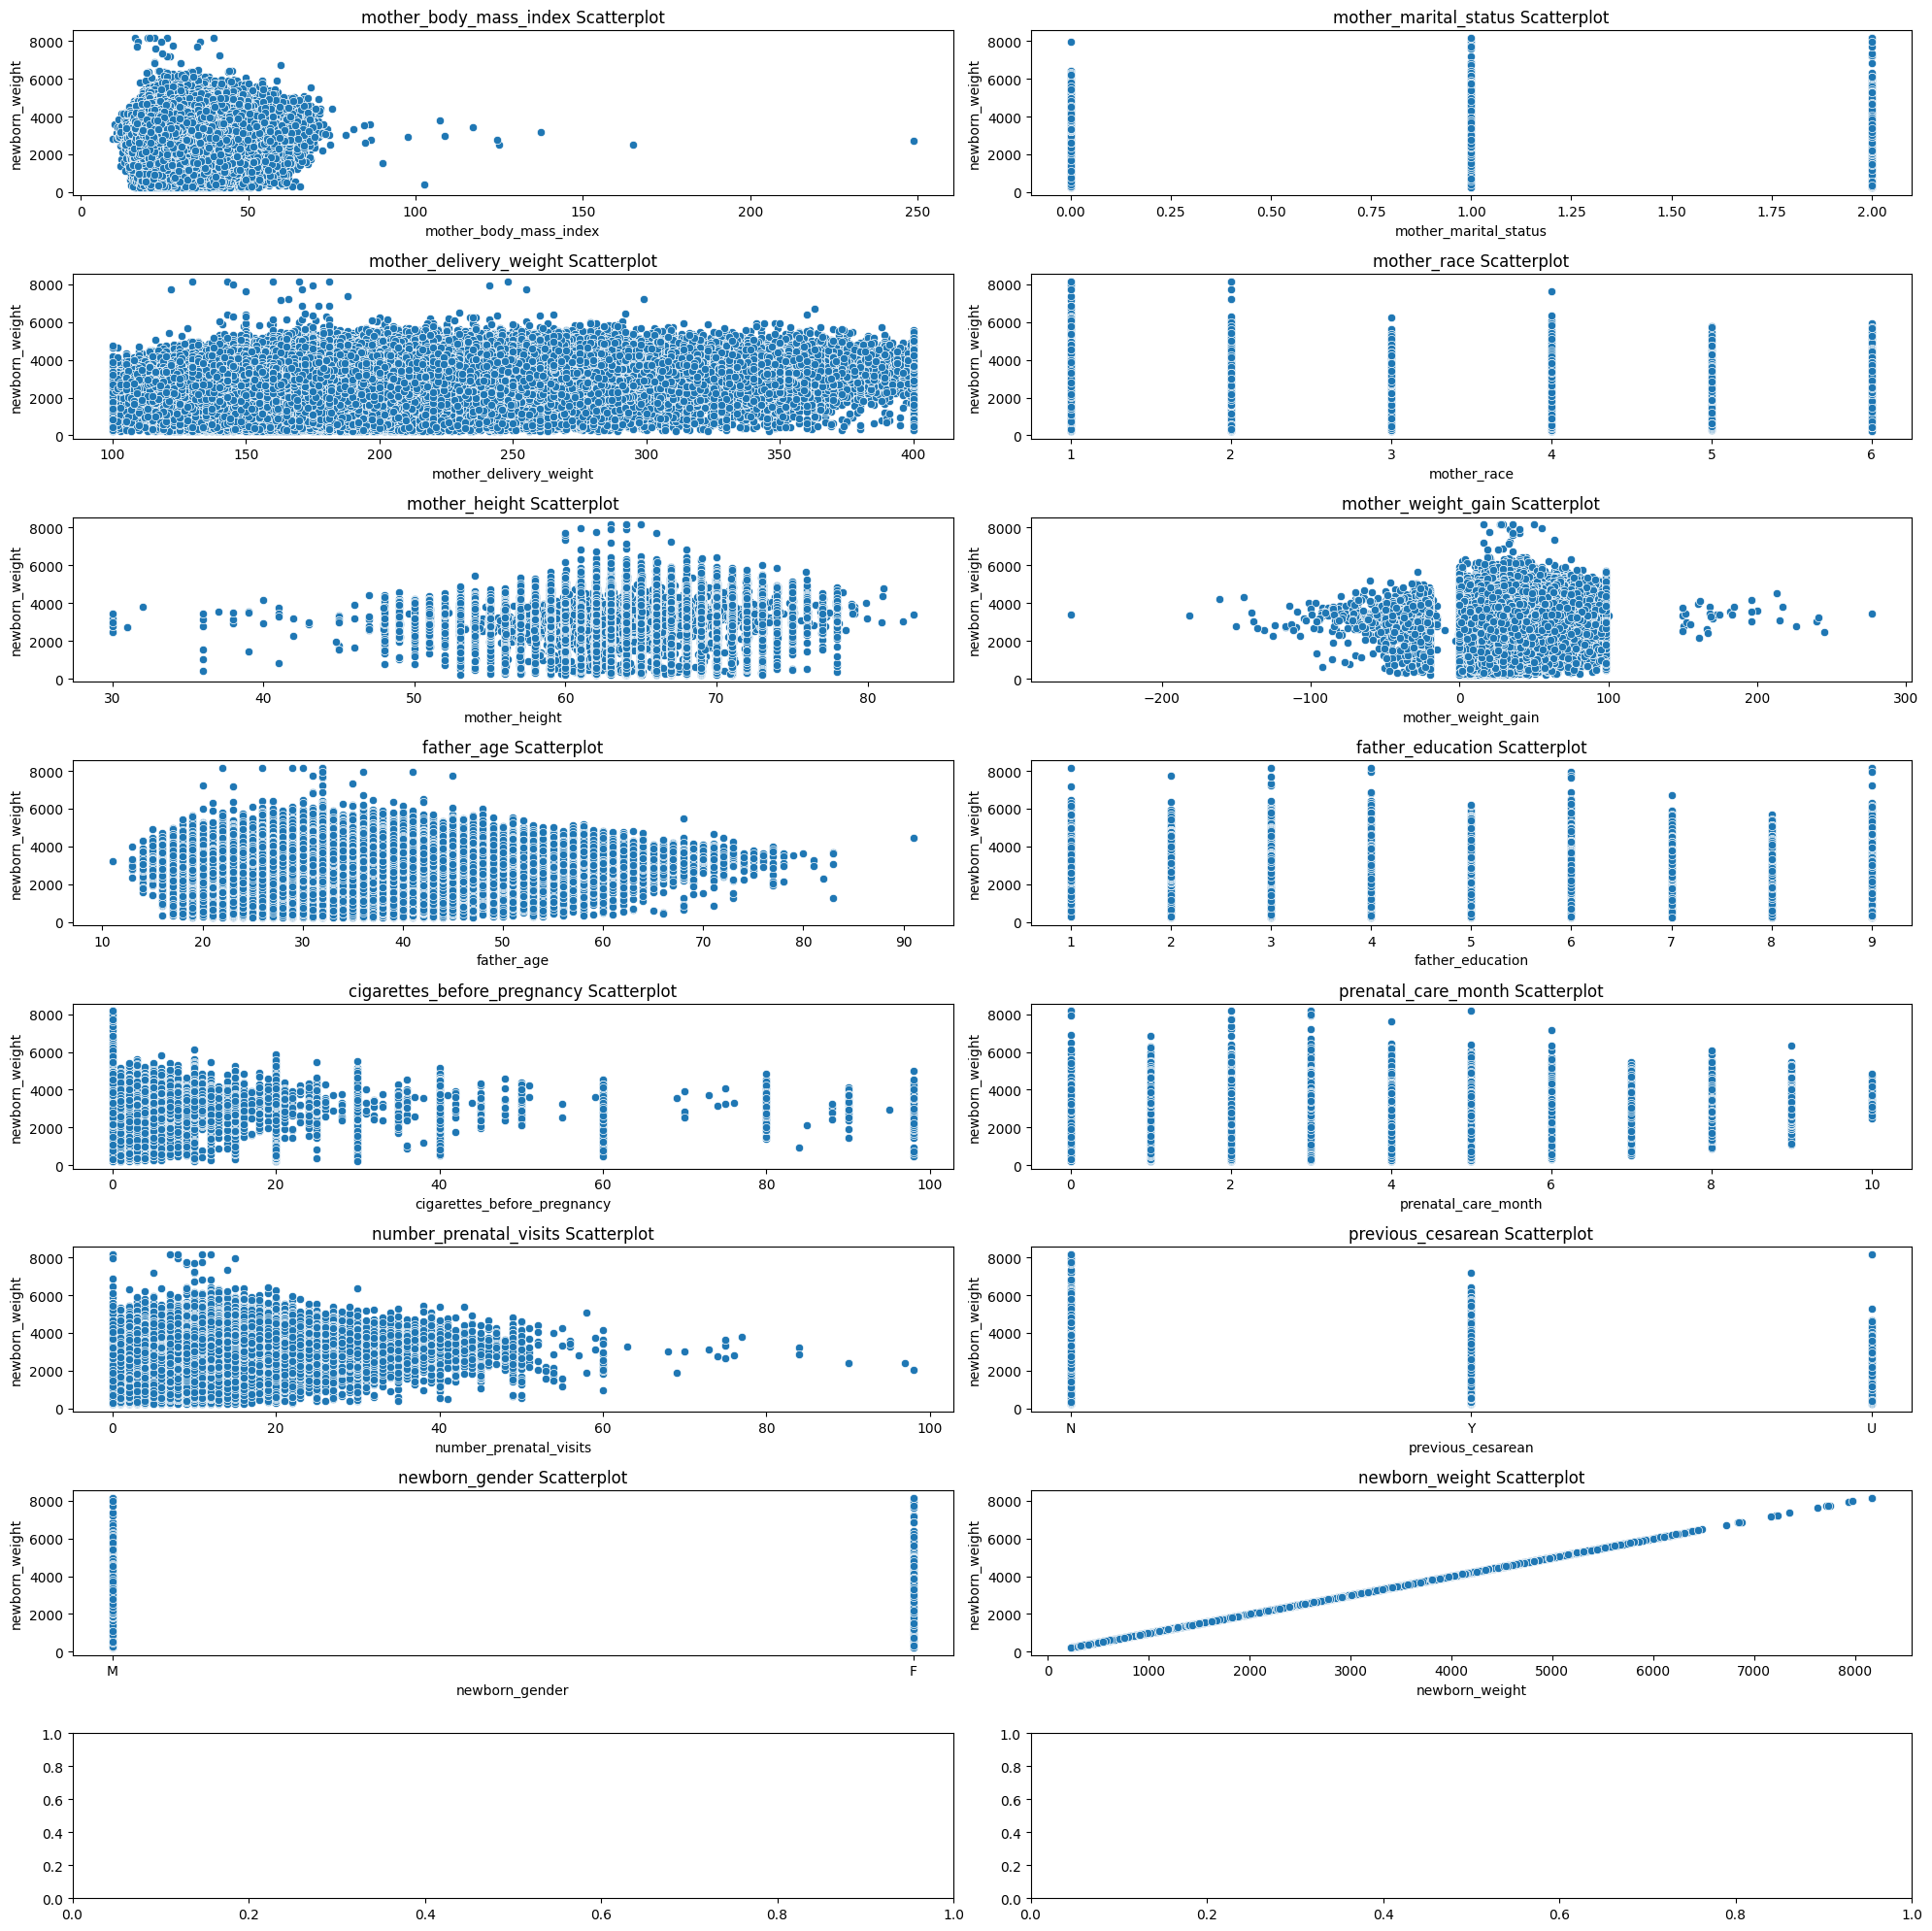

In [122]:
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)

axes = axes.flatten()

columns = df.columns

for i, column in enumerate(columns):

    ax = axes[i]
    sns.scatterplot(data=df, x=column, y='newborn_weight', ax=ax)
    ax.set_title(column + " Scatterplot")
    ax.set_xlabel(column)
    ax.set_ylabel("newborn_weight")

plt.tight_layout()
plt.show()

### Deleting outliers

Log Transformation & Deleting outliers

In [123]:
df.loc[df['mother_body_mass_index'] > 80, 'mother_body_mass_index'] = 80
df.loc[df['number_prenatal_visits'] > 60, 'number_prenatal_visits'] = 60
df.loc[df['father_age'] > 80, 'father_age'] = 80
df.loc[df['mother_height'] < 45, 'mother_height'] = 45
df['mother_delivery_weight_log'] = np.log(df['mother_delivery_weight'])
df['mother_body_mass_index_log'] = np.log(df['mother_body_mass_index'])

### Hot encoding

In [124]:
def feature_engineering(df):

    df.loc[df['mother_body_mass_index'] > 80, 'mother_body_mass_index'] = 80
    df.loc[df['number_prenatal_visits'] > 60, 'number_prenatal_visits'] = 60
    df.loc[df['father_age'] > 80, 'father_age'] = 80
    df.loc[df['mother_height'] < 45, 'mother_height'] = 45
    df['mother_delivery_weight_log'] = np.log(df['mother_delivery_weight'])
    df['mother_body_mass_index_log'] = np.log(df['mother_body_mass_index'])

    df = pd.get_dummies(df, columns=['mother_marital_status'], drop_first=True)
    df.rename(columns={'mother_marital_status_1.0': 'mother_marital_status_married', 
              'mother_marital_status_2.0': 'mother_marital_status_not_married'}, inplace=True)
    df['mother_marital_status_married'] = df['mother_marital_status_married'].astype(bool)
    df['mother_marital_status_not_married'] = df['mother_marital_status_not_married'].astype(bool)
    
    race_mapping = {
        1: 'White',
        2: 'Black',
        3: 'AIAN',
        4: 'Asian',
        5: 'NHOPI',
        6: 'More than one race'
    }
    race_columns = [f"mother_race_{value}" for value in race_mapping.values()]
    df = pd.get_dummies(df, columns=['mother_race'], drop_first=True)
    df.rename(columns={col: f"race_mapping_{race_mapping[int(col.split('_')[-1])]}" for col in df.columns if 'mother_race' in col}, inplace=True)
    df[race_columns] = df[race_columns].astype(bool)


    education_mapping = {
        1: 1,
        2: 1,
        3: 2,
        4: 2,
        5: 2,
        6: 3,
        7: 3,
        8: 4,
        9: 0
    }
    df['father_education'] = df['father_education'].map(education_mapping)

    #df['prenatal_care_month'] = df['prenatal_care_month'].replace([1, 2, 3], 1)
    #df['prenatal_care_month'] = df['prenatal_care_month'].replace([4, 5, 6], 2)
    #df['prenatal_care_month'] = df['prenatal_care_month'].replace([7, 8, 9, 10], 3)
    #encoded_columns = pd.get_dummies(df['prenatal_care_month'], prefix='prenatal_care')
    #encoded_columns.columns = encoded_columns.columns.str.replace('prenatal_care_', 'prenatal_care_')
    #df = pd.concat([df, encoded_columns], axis=1)

    df['previous_cesarean'] = df['previous_cesarean'].map({'Y': 1, 'N': 0, 'U': 0}).astype(bool)

    df['newborn_gender'] = (df['newborn_gender'] == 'M').astype(bool)

    df['smoker'] =(df['cigarettes_before_pregnancy'] > 0).astype(bool)
    

    return df



In [125]:
df

,mother_body_mass_index,mother_marital_status,mother_delivery_weight,mother_race,mother_height,mother_weight_gain,father_age,father_education,cigarettes_before_pregnancy,prenatal_care_month,number_prenatal_visits,previous_cesarean,newborn_gender,newborn_weight,mother_delivery_weight_log,mother_body_mass_index_log
1053544,39.2,1.0,275.0,1,67.000000,25.0,32.0,5,0.0,3,16.0,N,M,4054,5.616771,3.668677
1322528,39.0,0.0,218.0,1,63.000000,0.0,37.0,4,0.0,2,10.0,Y,M,3100,5.384495,3.663562
1359948,19.6,2.0,145.0,1,65.000000,27.0,32.0,7,0.0,3,13.0,N,F,3165,4.976734,2.975530
1260279,25.7,1.0,185.0,1,64.055545,35.0,35.0,7,0.0,0,14.0,N,F,3700,5.220356,3.246491
2162081,28.6,2.0,186.0,1,65.000000,14.0,28.0,4,0.0,3,11.0,N,F,4054,5.225747,3.353407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,33.0,1.0,243.0,1,64.000000,51.0,37.0,3,20.0,2,8.0,N,M,3260,5.493061,3.496508
1692743,35.0,1.0,205.0,1,64.000000,1.0,31.0,6,0.0,2,10.0,N,F,3005,5.323010,3.555348
2356330,26.9,1.0,208.0,1,64.000000,51.0,28.0,4,10.0,3,7.0,Y,F,3410,5.337538,3.292126
2229084,23.0,0.0,200.0,1,70.000000,40.0,41.0,8,0.0,1,12.0,N,F,3320,5.298317,3.135494


In [126]:
df_test = feature_engineering(df_test)
df = feature_engineering(df)

KeyError: "None of [Index(['mother_race_White', 'mother_race_Black', 'mother_race_AIAN',\n       'mother_race_Asian', 'mother_race_NHOPI',\n       'mother_race_More than one race'],\n      dtype='object')] are in the [columns]"

In [79]:
df.columns

Index(['mother_body_mass_index', 'mother_marital_status',
       'mother_delivery_weight', 'mother_race', 'mother_height',
       'mother_weight_gain', 'father_age', 'father_education',
       'cigarettes_before_pregnancy', 'prenatal_care_month',
       'number_prenatal_visits', 'previous_cesarean', 'newborn_gender',
       'newborn_weight', 'mother_delivery_weight_log',
       'mother_body_mass_index_log'],
      dtype='object')

In [ ]:
df = df.reset_index(drop=True)


In [ ]:
num_missing = df.isna().sum()
num_missing = num_missing[num_missing > 0]

percent_missing = num_missing * 100 / df.shape[0]
pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)


,Missing Values,Percentage


In [ ]:
#quick_viz(df['mother_body_mass_index'])

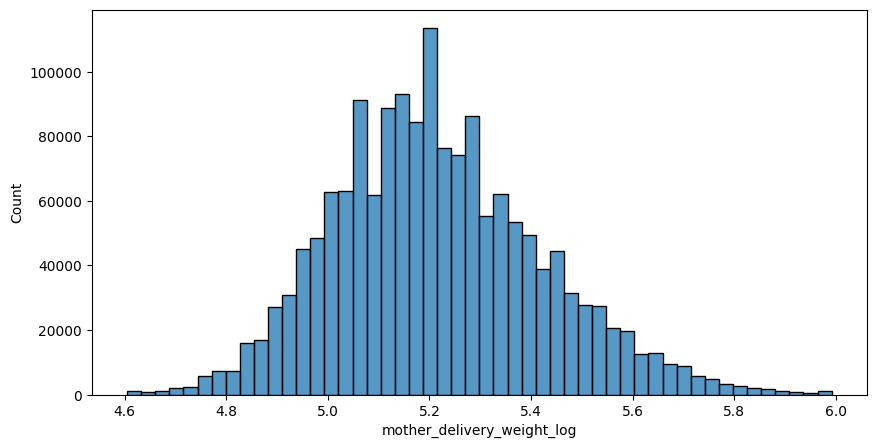

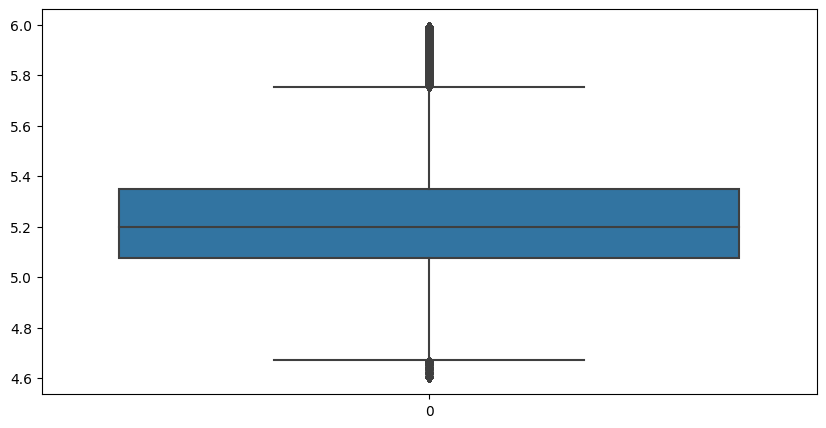

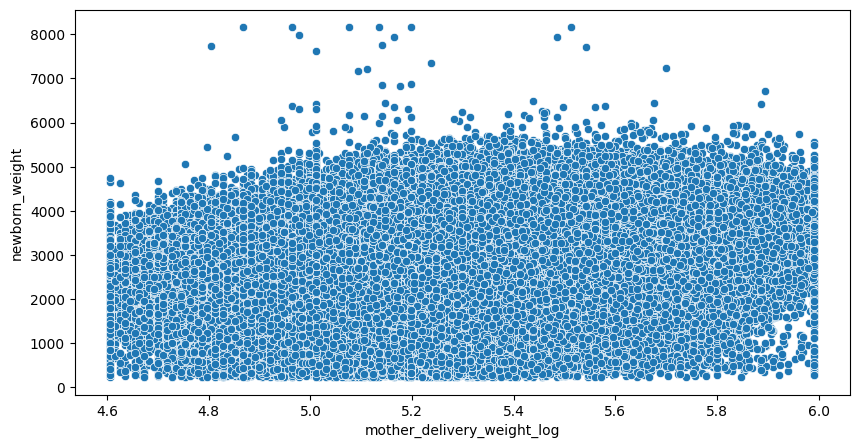

In [ ]:
quick_viz(df['mother_delivery_weight_log'])

## Feature Selection

### Sampling the data

In [ ]:
df.columns

Index(['mother_body_mass_index', 'mother_delivery_weight', 'mother_height',
       'mother_weight_gain', 'father_age', 'father_education',
       'cigarettes_before_pregnancy', 'prenatal_care_month',
       'number_prenatal_visits', 'previous_cesarean', 'newborn_gender',
       'newborn_weight', 'mother_delivery_weight_log',
       'mother_body_mass_index_log', 'mother_marital_status_1.0',
       'mother_marital_status_2.0', 'mother_race_2', 'mother_race_3',
       'mother_race_4', 'mother_race_5', 'mother_race_6', 'smoker'],
      dtype='object')

In [ ]:
y_col = ['newborn_weight']

In [ ]:
x_col = ['mother_body_mass_index', 'mother_delivery_weight', 'mother_height',
       'mother_weight_gain', 'father_age', 'father_education',
       'cigarettes_before_pregnancy', 'prenatal_care_month',
       'number_prenatal_visits', 'previous_cesarean', 'newborn_gender',
        'mother_delivery_weight_log',
       'mother_body_mass_index_log',
       'mother_marital_status_1.0', 'mother_marital_status_2.0',
       'mother_race_2', 'mother_race_3', 'mother_race_4', 'mother_race_5',
       'mother_race_6', 'smoker']

In [ ]:
df = df.sample(n=500000, random_state=42)
df = df.reset_index(drop=True)

In [ ]:
df_re = pd.DataFrame(StandardScaler().fit_transform(df.loc[:, x_col]), columns=x_col)


In [ ]:
#df = df.drop('newborn_weight', axis=1)
df = pd.concat([df_re, df[y_col]], axis=1)

In [ ]:
df['newborn_weight']

0         4054
1         3240
2         3610
3         3304
4         3770
          ... 
499995    2778
499996    2375
499997    3203
499998    3062
499999    3856
Name: newborn_weight, Length: 500000, dtype: int64

In [ ]:
df.dtypes

mother_body_mass_index         float64
mother_delivery_weight         float64
mother_height                  float64
mother_weight_gain             float64
father_age                     float64
father_education               float64
cigarettes_before_pregnancy    float64
prenatal_care_month            float64
number_prenatal_visits         float64
previous_cesarean              float64
newborn_gender                 float64
mother_delivery_weight_log     float64
mother_body_mass_index_log     float64
mother_marital_status_1.0      float64
mother_marital_status_2.0      float64
mother_race_2                  float64
mother_race_3                  float64
mother_race_4                  float64
mother_race_5                  float64
mother_race_6                  float64
smoker                         float64
newborn_weight                   int64
dtype: object

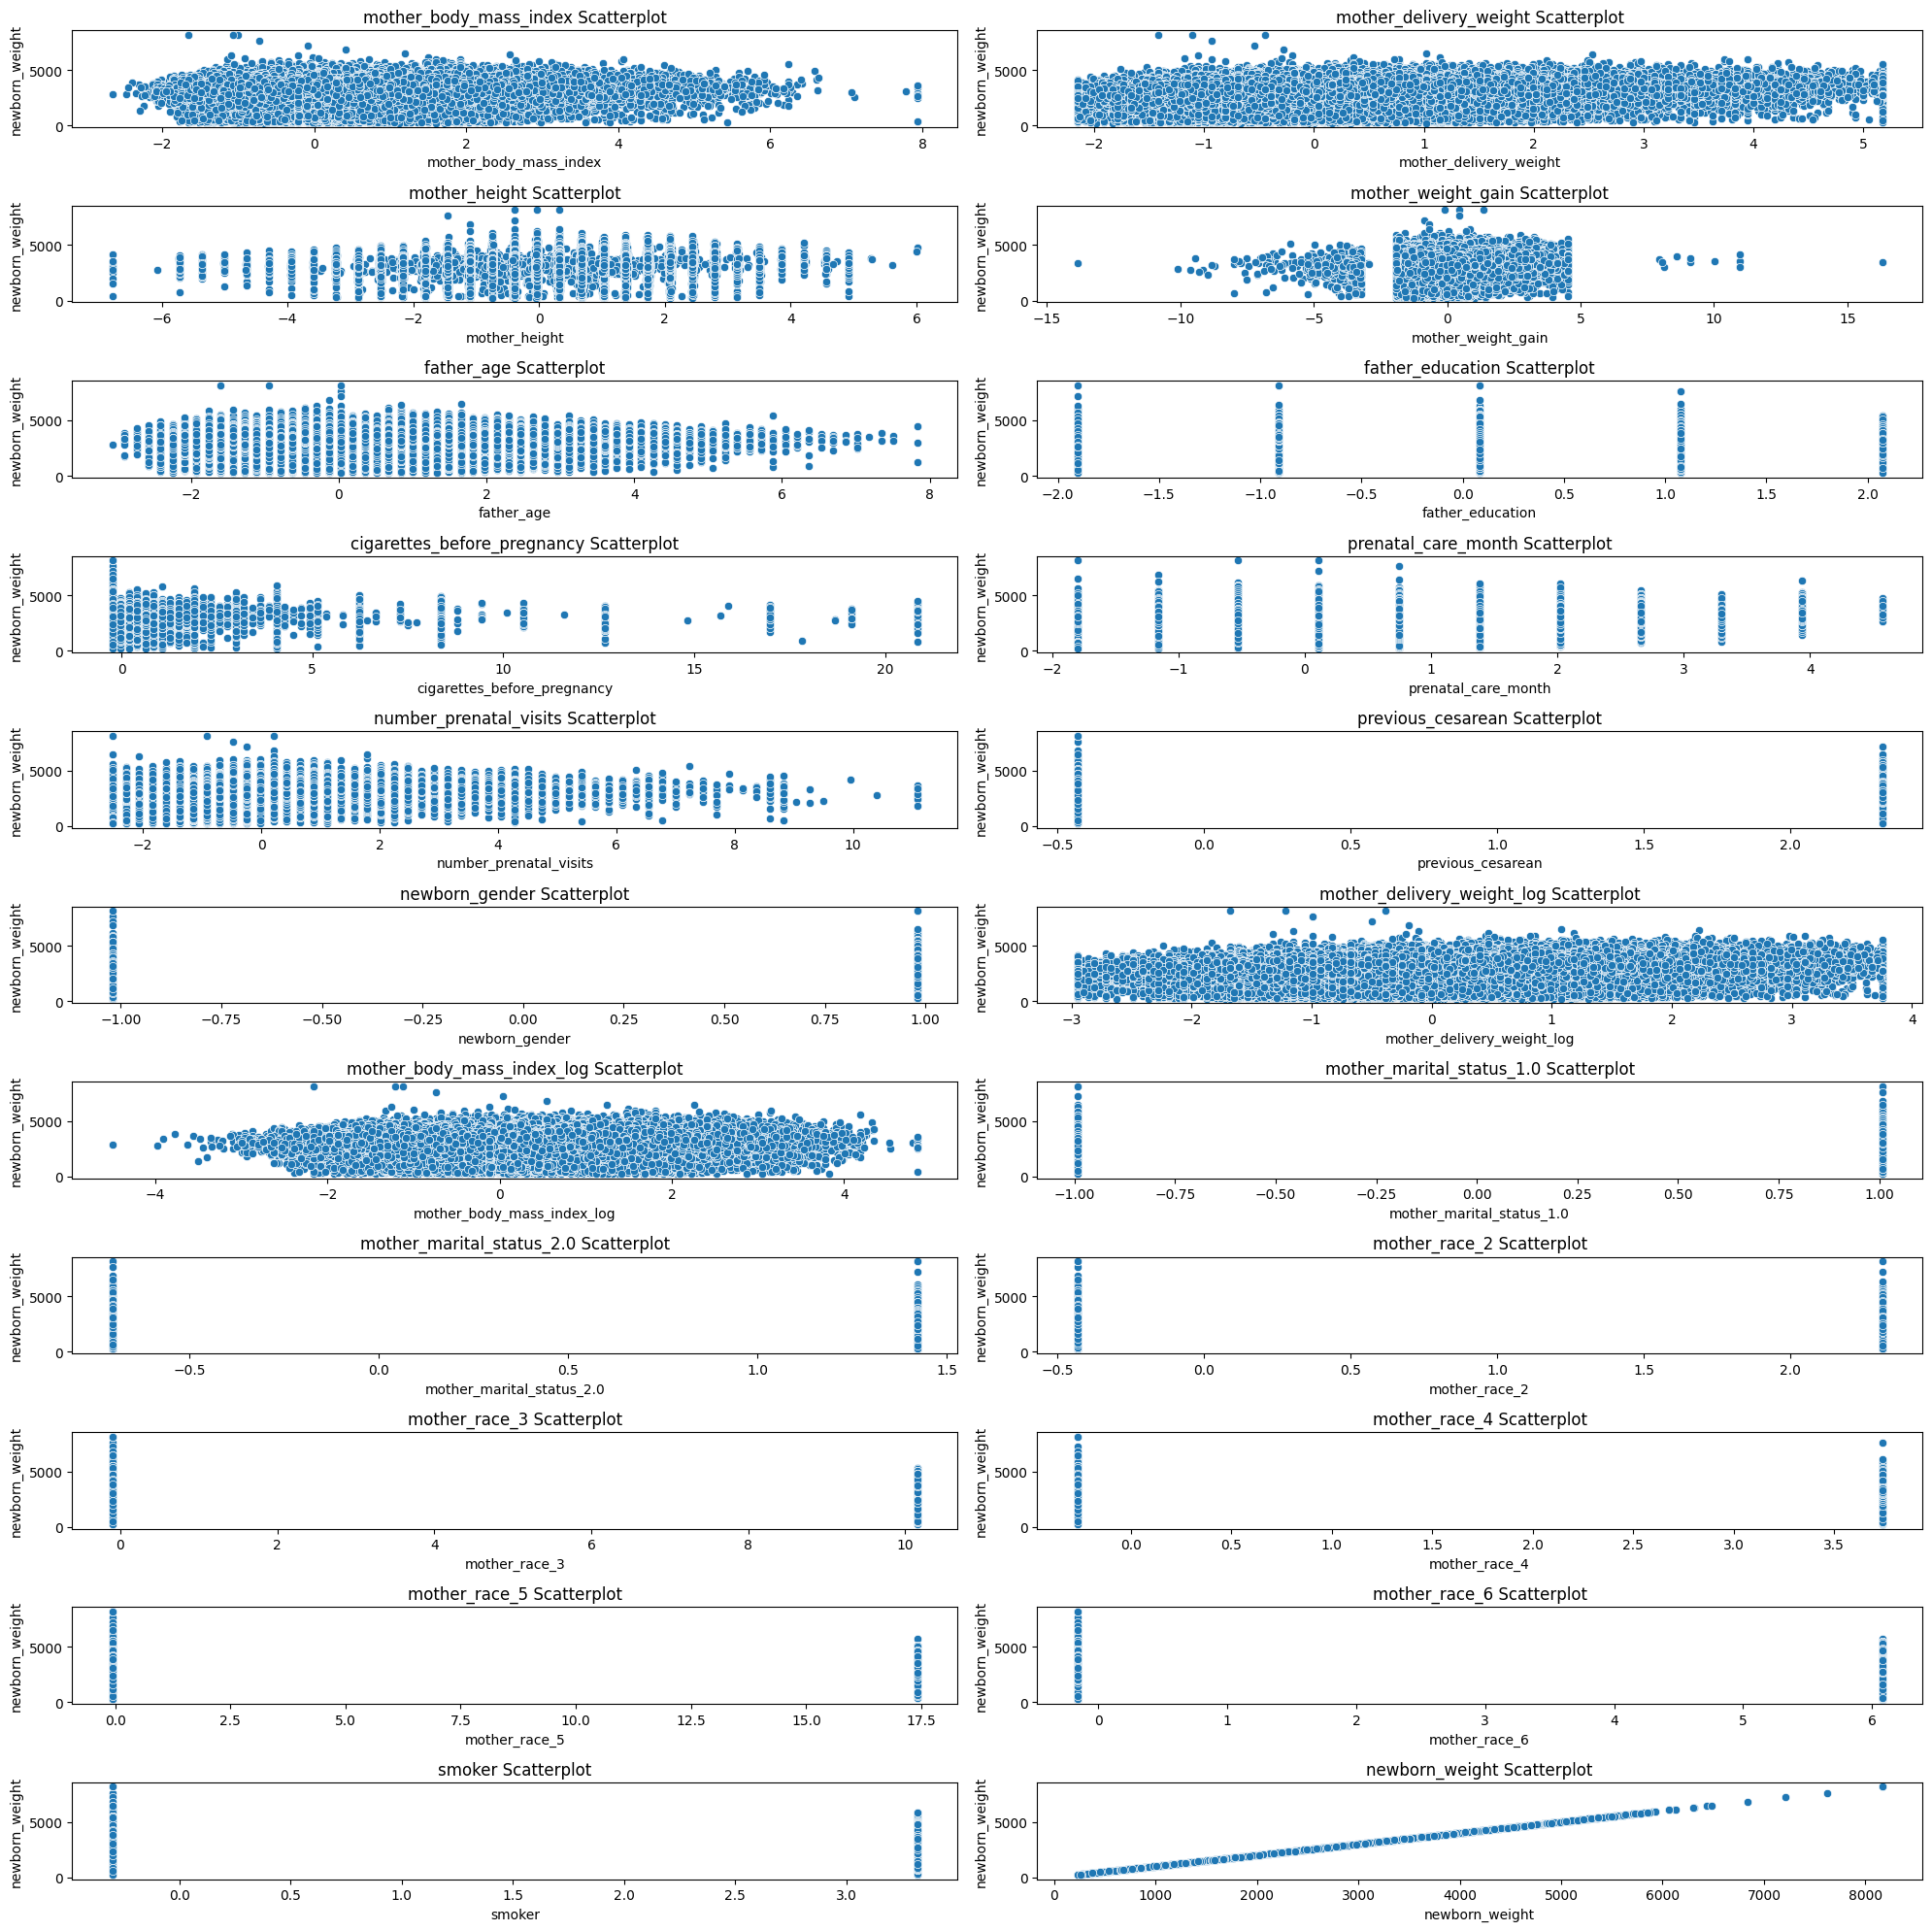

In [ ]:
fig, axes = plt.subplots(nrows=11, ncols=2, figsize=(20, 20))
fig.subplots_adjust(hspace=0.5)

axes = axes.flatten()

columns = df.columns

for i, column in enumerate(columns):

    ax = axes[i]
    sns.scatterplot(data=df, x=column, y='newborn_weight', ax=ax)
    ax.set_title(column + " Scatterplot")
    ax.set_xlabel(column)
    ax.set_ylabel("newborn_weight")

plt.tight_layout()
plt.show()

In [47]:
sel = VarianceThreshold(0.001)
sel_var = sel.fit_transform(df[x_col])
col_imp = df[x_col][df[x_col].columns[sel.get_support(indices=True)]].columns
col_redundant = set(df[x_col].columns.tolist()) - set(col_imp)


In [51]:
general_ranking = pd.DataFrame(index=x_col)

In [52]:
#sel_ = SelectFromModel(Lasso(alpha=0.005, random_state=10))
#sel_.fit(df[x_col], df[y_col])
#sel_.get_feature_names_out()

c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.151e+08, tolerance: 1.737e+07
  model = cd_fast.enet_coordinate_descent(


array(['mother_body_mass_index', 'mother_delivery_weight',
       'mother_height', 'mother_weight_gain', 'father_age',
       'father_education', 'cigarettes_before_pregnancy',
       'prenatal_care_month', 'number_prenatal_visits',
       'previous_cesarean', 'newborn_gender',
       'mother_delivery_weight_log', 'mother_body_mass_index_log',
       'mother_marital_status_1.0', 'mother_marital_status_2.0',
       'mother_race_2', 'mother_race_3', 'mother_race_4', 'mother_race_5',
       'mother_race_6', 'smoker'], dtype=object)

## Correlation

<Axes: >

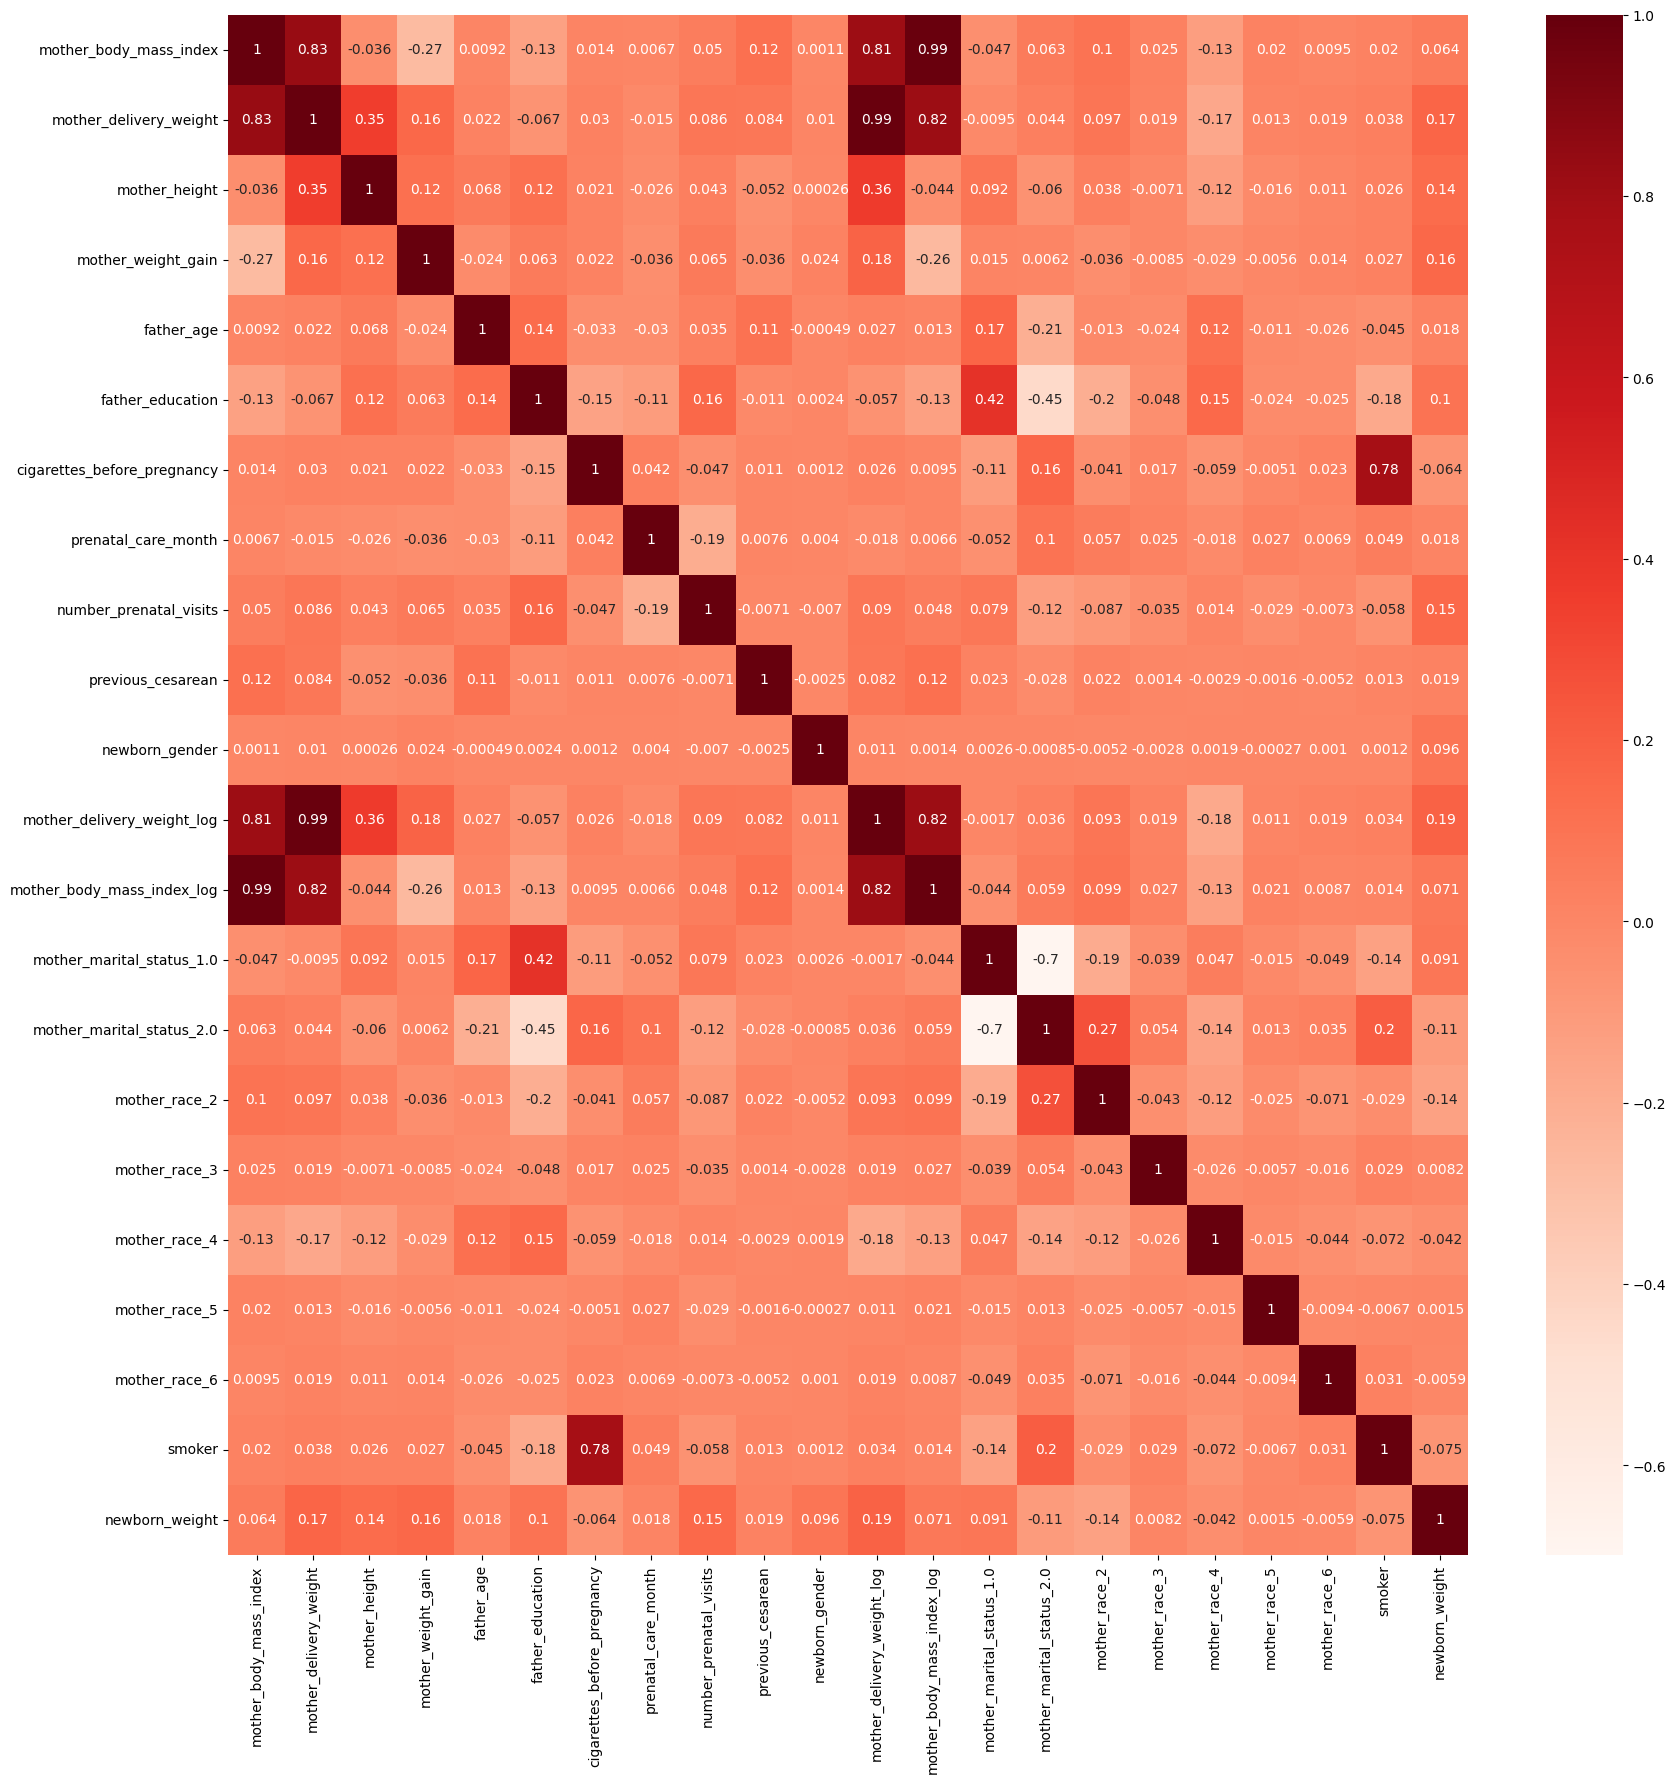

In [60]:
cor = df.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

### Mutual information

In [224]:
mi = dict()
for i in x_col:
    mi.update({i: mutual_info_regression(df[[i]].values, df[y_col].values.ravel())[0]})

In [225]:
miDF = pd.DataFrame.from_dict(mi, orient="index", columns=["score"])

In [226]:
miDF.sort_values(by="score").head(10)

,score
mother_race_5,0.000000
mother_race_3,0.000000
mother_race_6,0.000329
cigarettes_before_pregnancy,0.002174
previous_cesarean,0.002720
smoker,0.003153
mother_race_4,0.003987
father_education,0.005367
mother_marital_status_1.0,0.006092
father_age,0.006129


In [227]:
miDF.sort_values(by="score", ascending=False).head(10)

,score
mother_delivery_weight,0.035784
mother_delivery_weight_log,0.034932
number_prenatal_visits,0.025493
mother_weight_gain,0.018624
mother_height,0.014606
mother_body_mass_index,0.012344
mother_body_mass_index_log,0.011418
mother_race_2,0.010454
mother_marital_status_2.0,0.008857
newborn_gender,0.007954


In [228]:
general_ranking = pd.merge(general_ranking, miDF, left_index=True, right_index=True)
general_ranking.rename(columns={"score": "mi_score"}, inplace=True)

### F-score

In [229]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
fscore = dict()
for i in x_col:
    fscore.update({i: f_regression(df[[i]].values, df[y_col].values.ravel())[1]})

In [230]:
fscoreDF = pd.DataFrame.from_dict(fscore, orient="index", columns=["p_value_score"])
fscoreDF.sort_values(by="p_value_score").head(10)

,p_value_score
mother_body_mass_index,0.0
mother_race_2,0.0
mother_marital_status_2.0,0.0
mother_marital_status_1.0,0.0
mother_body_mass_index_log,0.0
mother_delivery_weight_log,0.0
number_prenatal_visits,0.0
newborn_gender,0.0
cigarettes_before_pregnancy,0.0
father_education,0.0


In [231]:
fscoreDF.sort_values(by="p_value_score", ascending=False).head(10)

,p_value_score
mother_race_5,2.934688e-01
mother_race_6,2.967512e-05
mother_race_3,6.773657e-09
mother_marital_status_0.0,2.151007e-18
prenatal_care_month,2.491900e-35
father_age,4.845727e-38
previous_cesarean,3.354504e-39
mother_race_4,1.302392e-189
mother_body_mass_index,0.000000e+00
mother_race_2,0.000000e+00


In [232]:
general_ranking = pd.merge(general_ranking, fscoreDF, left_index=True, right_index=True)

In [233]:
general_ranking.rename(
    columns={"p_value_score": "sign_fscore", "sign": "sign_fscore_0_1"}, inplace=True
)

### Boruta

In [234]:
#rf = RandomForestRegressor(n_jobs=-1, max_depth=5)
#feat_selector = bp(rf, n_estimators="auto", verbose=0, max_iter=100)
#feat_selector.fit(x_train, y_train.ravel())

### ElasticNet

In [235]:
#scaler = StandardScaler()
#df.loc[:, df.columns != 'newborn_weight'] = scaler.fit_transform(
#    df.loc[:, df.columns != 'newborn_weight'])

In [249]:
def mape_cv(model, df):
    mape = cross_val_score(
            model,
            df.loc[:, x_col],
            df.loc[:, y_col],
            scoring='neg_mean_absolute_percentage_error',
            cv=5,
    )
    return mape

In [248]:
alphas = [0.0001, 0.001, 0.01, 0.03]
l1_ratios = [1,0.8, 0.5, 0.3, 0.1]

In [238]:
cv_elastic = [
    mape_cv(ElasticNet(alpha=alpha, l1_ratio=l1_ratio, tol = 0.5), df).mean()
    for (alpha, l1_ratio) in product(alphas, l1_ratios)
]

Text(0, 0.5, 'mape')

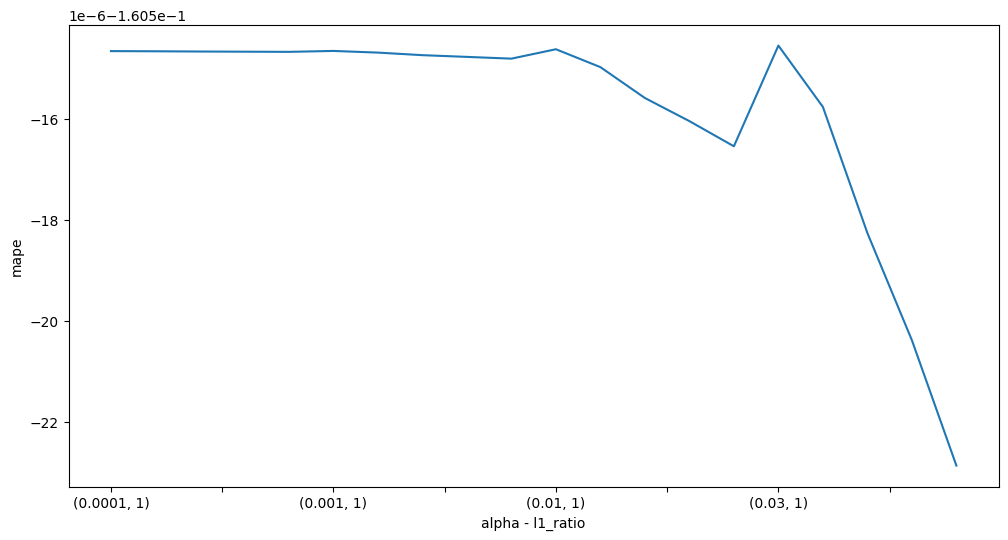

In [239]:
plt.rcParams["figure.figsize"] = (12.0, 6.0)
idx = list(product(alphas, l1_ratios))
p_cv_elastic = pd.Series(cv_elastic, index=idx)
p_cv_elastic.plot()
plt.xlabel("alpha - l1_ratio")
plt.ylabel("mape")

In [240]:
cv_elastic

[-0.16051464803583645,
 -0.16051465131438816,
 -0.16051465623662026,
 -0.16051465952033683,
 -0.1605146628139949,
 -0.1605146446064234,
 -0.16051467772869152,
 -0.16051472850542944,
 -0.1605147627632201,
 -0.16051479763125878,
 -0.1605146109294952,
 -0.1605149660188883,
 -0.16051557879353168,
 -0.16051603759448269,
 -0.1605165368332246,
 -0.16051453832963195,
 -0.16051575595714257,
 -0.16051825825669858,
 -0.1605203852842886,
 -0.1605228739063112]

In [241]:
def run_elastic_net(sample_1):
    elastic = ElasticNet(alpha=1, l1_ratio=0.5)
    elastic.fit(sample_1.loc[:, x_col], sample_1.loc[:, y_col])
    coef = pd.Series(elastic.coef_, index=sample_1.loc[:, x_col].columns)
    print(
        "Elastic Net picked "
        + str(sum(coef != 0))
        + " variables and eliminated the other "
        + str(sum(coef == 0))
        + " variables"
    )
    return coef.sort_values()
    imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
    plt.rcParams["figure.figsize"] = (8.0, 10.0)
    imp_coef.plot(kind="barh")
    plt.title("Coefficients in the Elastic Net Model")
    plt.show()




Elastic Net picked 22 variables and eliminated the other 0 variables


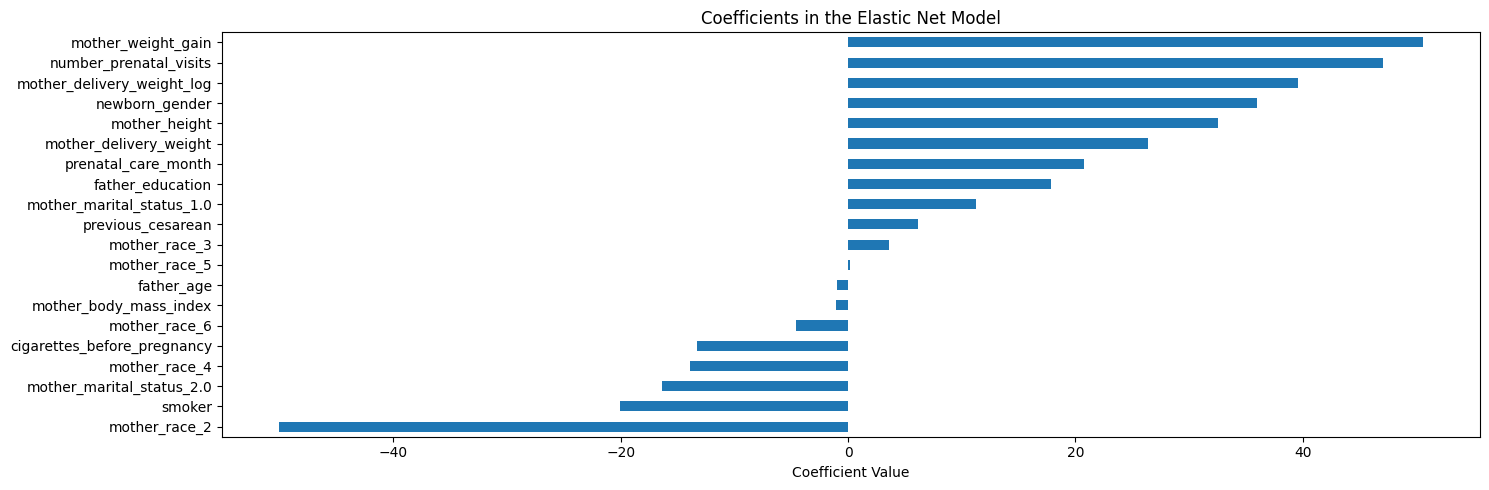

In [242]:
coef = run_elastic_net(df)
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
fig, ax = plt.subplots(figsize=(15, 5))
imp_coef.plot(kind="barh", ax=ax)
ax.set_title("Coefficients in the Elastic Net Model")
ax.set_xlabel("Coefficient Value")

plt.tight_layout()
plt.show()

In [243]:
coef = run_elastic_net(sample_1)
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

NameError: name 'sample_1' is not defined

Elastic Net picked 1 variables and eliminated the other 29 variables
Elastic Net picked 1 variables and eliminated the other 29 variables
Elastic Net picked 1 variables and eliminated the other 29 variables


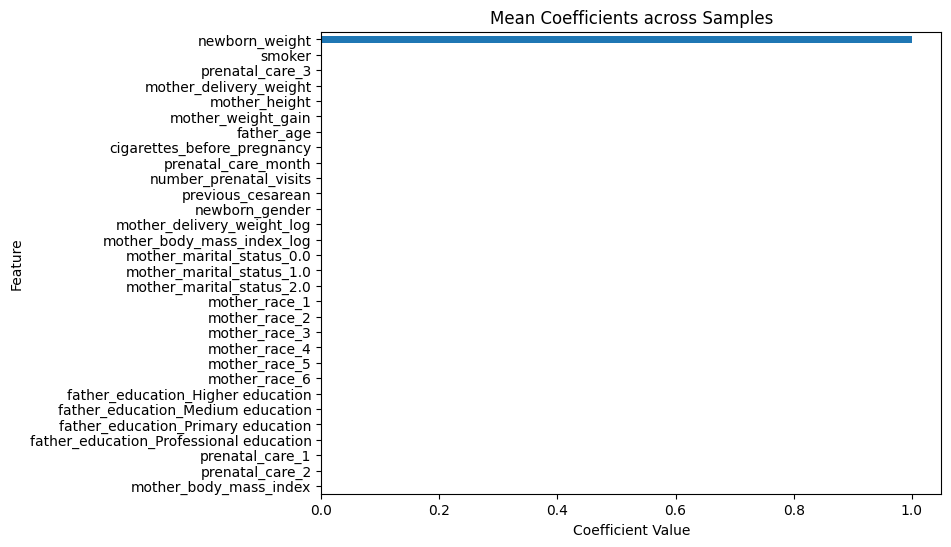

In [ ]:
coefficients = pd.DataFrame()

# Run the Elastic Net and store the coefficients for each sample
for i, sample in enumerate(samples):
    coef = run_elastic_net(sample)
    coefficients['Sample ' + str(i+1)] = coef

# Calculate the mean of coefficients across the samples
mean_coefficients = coefficients.mean(axis=1)

# Plot the mean coefficients
plt.figure(figsize=(8, 6))
mean_coefficients.plot(kind="barh")
plt.title("Mean Coefficients across Samples")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.show()

In [ ]:
general_ranking = pd.merge(
    general_ranking,
    pd.DataFrame(imp_coef),
    left_index=True,
    right_index=True,
    how="left",
)

In [ ]:
corr = list()
for i in x_col:
    corr.append(stats.spearmanr(sample_1.loc[:, y_col].values, sample_1.loc[:, i].values)[0])
    

In [ ]:
general_ranking = pd.merge(
    general_ranking,
    pd.DataFrame(corr, index=x_col, columns=["corr"]),
    left_index=True,
    right_index=True,
)

In [ ]:
pd.set_option("display.max_rows", 500)

In [ ]:
general_ranking.sort_values(["mi_score","corr"], ascending=False)

,mi_score,sign_fscore,0,corr
newborn_weight,1.409951,0.000000e+00,0.999997,1.000000
mother_delivery_weight,0.035626,0.000000e+00,0.000000,0.210018
mother_delivery_weight_log,0.034466,0.000000e+00,NaN,0.210018
number_prenatal_visits,0.026552,0.000000e+00,0.000000,0.151811
mother_weight_gain,0.018225,0.000000e+00,0.000000,0.173592
mother_height,0.014862,0.000000e+00,0.000000,0.159227
mother_body_mass_index_log,0.012712,0.000000e+00,NaN,0.088134
mother_body_mass_index,0.010185,0.000000e+00,0.000000,0.088134
mother_race_1,0.009967,0.000000e+00,NaN,0.143148
mother_race_2,0.009407,0.000000e+00,NaN,-0.135876


In [ ]:
import openpyxl


In [ ]:
general_ranking.to_excel("data/output/feature_ranking.xlsx")
df.to_csv("data/output/train_fe.csv")
df_test.to_csv("data/output/test_fe.csv")

